_Ref: https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f_

In [54]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

# Load and transform

In [55]:
df=pd.read_csv('AAL.csv')
print('Number of rows and columns:', df.shape)
length = df.shape[0]
print(len)
df.head()

Number of rows and columns: (3020, 7)
<built-in function len>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,4.84,4.94,4.66,4.77,4.496877,9837300
1,2010-01-05,4.79,5.37,4.71,5.31,5.005957,25212000
2,2010-01-06,5.19,5.38,5.00,5.09,4.798554,16597900
3,2010-01-07,5.06,5.43,5.05,5.24,4.939965,14033400
4,2010-01-08,5.27,5.43,5.06,5.14,4.845692,12760000


`close_log`: $log\frac{Price_t}{Price_{t-1}}\;\;\;\;\;$
`target_log`: $log\frac{Price_{t+33}}{Price_{t+28}}$

In [56]:
seq_length = 30
step_predict = 5

In [57]:
df['close_log'] = np.log(df['Close'] / df['Close'].shift(1))
df['vol_log'] = np.log(df['Volume'] / df['Volume'].shift(1))
df['target_log'] = np.log(df['Close'].shift(-step_predict) / df['Close'])

print(df['close_log'])

0            NaN
1       0.107246
2      -0.042314
3       0.029044
4      -0.019268
          ...   
3015    0.000000
3016   -0.004941
3017    0.020159
3018   -0.026785
3019    0.001107
Name: close_log, Length: 3020, dtype: float64


In [58]:
train_df = df[int(length*0.7):int(length*0.9)].copy()
train_df.reset_index(inplace=True)
val_df = df[int(length*0.9):int(length*0.95)].copy()
val_df.reset_index(inplace=True)
test_df = df.loc[int(length*0.95):].copy()
test_df.reset_index(inplace=True)
train_df.shape, val_df.shape, test_df.shape

((604, 11), (151, 11), (151, 11))

`sequence`: $\left[log\frac{Price_t}{Price_{t-1}},log\frac{Price_{t+1}}{Price_{t}}, \dots,log\frac{Price_{t+28}}{Price_{t+27}}\right]$

In [59]:
# sc = MinMaxScaler().fit(train_df[1: train_df.shape[0]-step_predict].close_log.values.reshape(-1, 1))
# sequences = sc.transform(train_df[1: train_df.shape[0]-step_predict].close_log.values)
X_train = []
y_train = []
for i in range(seq_length, train_df.shape[0]-step_predict):
    X_train.append(train_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_train.append(train_df.loc[i-1, 'target_log'])
X_train, y_train= np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
X_train.shape, y_train.shape

((569, 29, 2), (569,))

In [60]:
X_val = []
y_val = []
for i in range(seq_length, val_df.shape[0]-step_predict):
    X_val.append(val_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_val.append(val_df.loc[i-1, 'target_log'])
X_val, y_val= np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 2))
X_val.shape, y_val.shape

((116, 29, 2), (116,))

# Model

In [61]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

## LSTM

In [62]:
inputs = Input(shape=(X_train.shape[1], 2))
lstm1 = LSTM(units=50, return_sequences=True)(inputs)
dropout1 = Dropout(rate=0.5)(lstm1)
lstm2 = LSTM(units=50, return_sequences=True)(dropout1)
dropout2 = Dropout(rate=0.5)(lstm2)
lstm3 = LSTM(units=50)(dropout2)
dropout3 = Dropout(rate=0.5)(lstm3)
fc1 = Dense(units=100)(dropout3)
fc2 = Dense(units=50)(fc1)
fc3 = Dense(units=25)(fc2)
output = Dense(units=1)(fc3)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data=(X_val, y_val))

Epoch 1/100
18/18 [==============================] - 9s 115ms/step - loss: 0.0111 - val_loss: 0.0065
Epoch 2/100
18/18 [==============================] - 1s 45ms/step - loss: 0.0109 - val_loss: 0.0051
Epoch 3/100
18/18 [==============================] - 1s 41ms/step - loss: 0.0106 - val_loss: 0.0056
Epoch 4/100
18/18 [==============================] - 1s 40ms/step - loss: 0.0105 - val_loss: 0.0061
Epoch 5/100
18/18 [==============================] - 1s 41ms/step - loss: 0.0109 - val_loss: 0.0047
Epoch 6/100
18/18 [==============================] - 1s 40ms/step - loss: 0.0107 - val_loss: 0.0050
Epoch 7/100
18/18 [==============================] - 1s 42ms/step - loss: 0.0105 - val_loss: 0.0048
Epoch 8/100
18/18 [==============================] - 1s 43ms/step - loss: 0.0105 - val_loss: 0.0058
Epoch 9/100
18/18 [==============================] - 1s 40ms/step - loss: 0.0106 - val_loss: 0.0051
Epoch 10/100
18/18 [==============================] - 1s 41ms/step - loss: 0.0106 - val_loss: 0.004

In [63]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 29, 2)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 29, 50)            10600     
                                                                 
 dropout_6 (Dropout)         (None, 29, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 29, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 29, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0   

In [64]:
# model = Sequential()
# model.add(InputLayer(input_shape=(X_train.shape[1], 2)))
# #add model layers
# model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2)))
# model.add(TimeDistributed(Conv1D(256, kernel_size=1, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2)))
# model.add(TimeDistributed(Conv1D(512, kernel_size=1, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2)))
# model.add(TimeDistributed(Flatten()))
# model.add(Bidirectional(LSTM(200,return_sequences=True)))
# model.add(Dropout(0.25))
# model.add(Bidirectional(LSTM(200,return_sequences=False)))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='linear'))
# model.compile(optimizer='adam', loss='mse')
# model.fit(X_train, y_train, epochs = 200, batch_size = 32, validation_data=(X_val, y_val))

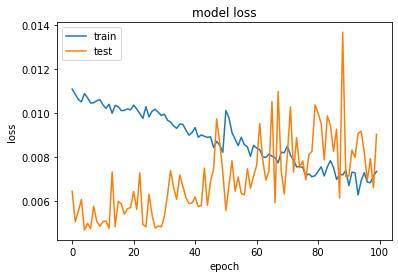

In [65]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predict and plot

### Train set

In [66]:
train_price = train_df[seq_length+step_predict:train_df.shape[0]].Close
# train_predicted = lstm_model.predict(X_train)
train_predicted = model.predict(X_train)
# train_predicted = sc.inverse_transform(train_predicted)
inv = train_df[seq_length:train_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
train_predicted = inv * np.exp(1)**train_predicted
len(train_price), len(train_predicted)

(569, 569)

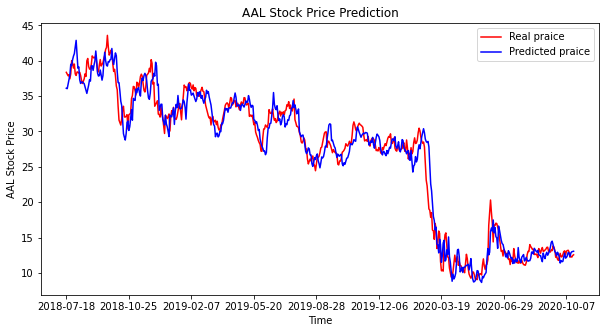

MSE: 3.318014643950254
MAE: 1.3771469214894394
R^2: 0.9641157254086538


In [67]:
# Visualising the results
date = train_df[seq_length+step_predict:train_df.shape[0]].Date.values
plt.figure(figsize=(10,5))
plt.plot(date, train_price, color = 'red', label = 'Real praice')
plt.plot(date, train_predicted, color = 'blue', label = 'Predicted praice')
# plt.plot(train_price, color = 'red', label = 'Real praice')
# plt.plot(train_predicted, color = 'blue', label = 'Predicted praice')
plt.xticks(np.arange(0,len(train_predicted),70))
plt.title('AAL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAL Stock Price')
plt.legend()
plt.show()
print(f'MSE: {mean_squared_error(train_price, train_predicted)}')
print(f'MAE: {mean_absolute_error(train_price, train_predicted)}')
print(f'R^2: {r2_score(train_price, train_predicted)}')

### Val set

In [68]:
val_price = val_df[seq_length+step_predict:val_df.shape[0]].Close
val_predicted = lstm_model.predict(X_val)
# val_predicted = sc.inverse_transform(val_predicted)
inv = val_df[seq_length:val_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
val_predicted = inv * np.exp(1)**val_predicted
len(val_price), len(val_predicted)

NameError: name 'lstm_model' is not defined

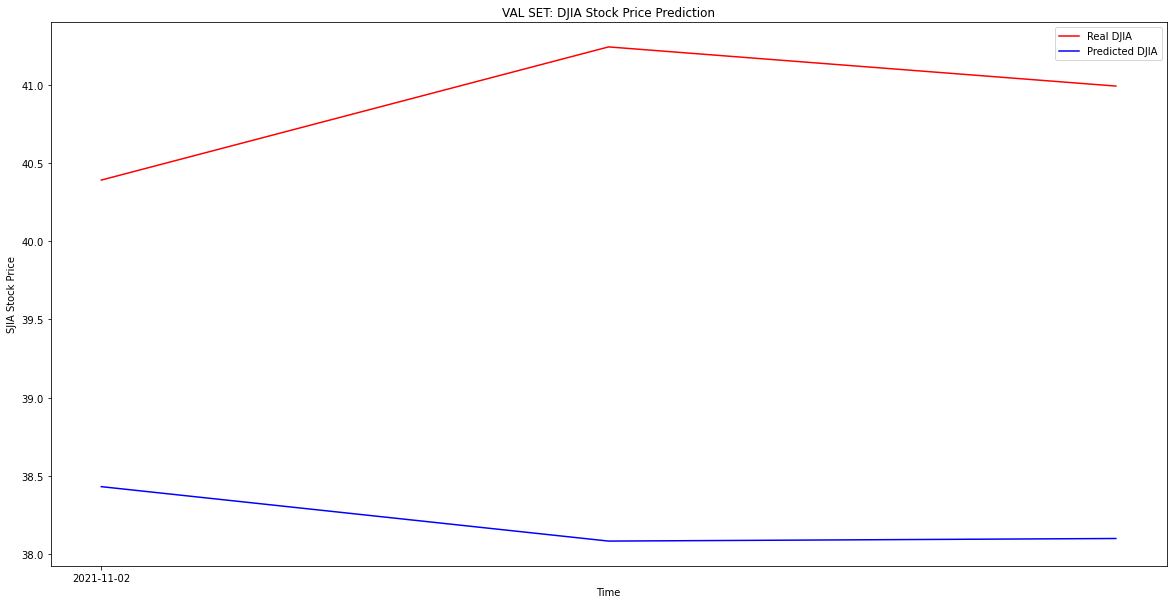

RMSE: 2.715490676715521


In [ ]:
# Visualising the results
date = val_df[seq_length+step_predict:val_df.shape[0]].Date.values
plt.figure(figsize=(20,10))
plt.plot(date, val_price, color = 'red', label = 'Real DJIA')
plt.plot(date, val_predicted, color = 'blue', label = 'Predicted DJIA')
plt.xticks(np.arange(0,len(val_predicted),50))
plt.title('VAL SET: DJIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SJIA Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(val_price, val_predicted, squared=False)}')

### Test set

In [ ]:
# sc = MinMaxScaler().fit(test_df[1: test_df.shape[0]-step_predict].close_log.values.reshape(-1, 1))
# x = sc.transform(test_df[1: test_df.shape[0]-step_predict].close_log.values.reshape(-1, 1))
# test_df.loc[1: test_df.shape[0]-step_predict-1, 'close_log'] = x

# sc = MinMaxScaler().fit(test_df[1: test_df.shape[0]-step_predict].vol_log.values.reshape(-1, 1))
# x = sc.transform(test_df[1: test_df.shape[0]-step_predict].vol_log.values.reshape(-1, 1))
# test_df.loc[1: test_df.shape[0]-step_predict-1, 'vol_log'] = x

# sc = MinMaxScaler().fit(test_df[1: test_df.shape[0]-step_predict].target_log.values.reshape(-1, 1))
# x = sc.transform(test_df[1: test_df.shape[0]-step_predict].target_log.values.reshape(-1, 1))
# test_df.loc[1: test_df.shape[0]-step_predict-1, 'target_log'] = x

In [ ]:
X_test = []
y_test = []
for i in range(seq_length, test_df.shape[0]-step_predict):
    X_test.append(test_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_test.append(test_df.loc[i-1, 'target_log'])
X_test, y_test= np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))
X_test.shape, y_test.shape

((3, 29, 2), (3,))

In [ ]:
test_price = test_df[seq_length+step_predict:test_df.shape[0]].Close
test_predicted = lstm_model.predict(X_test)
# test_predicted = sc.inverse_transform(test_predicted)
inv = test_df[seq_length:test_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
test_predicted = inv * np.exp(1)**test_predicted
len(test_price), len(test_predicted)

(3, 3)

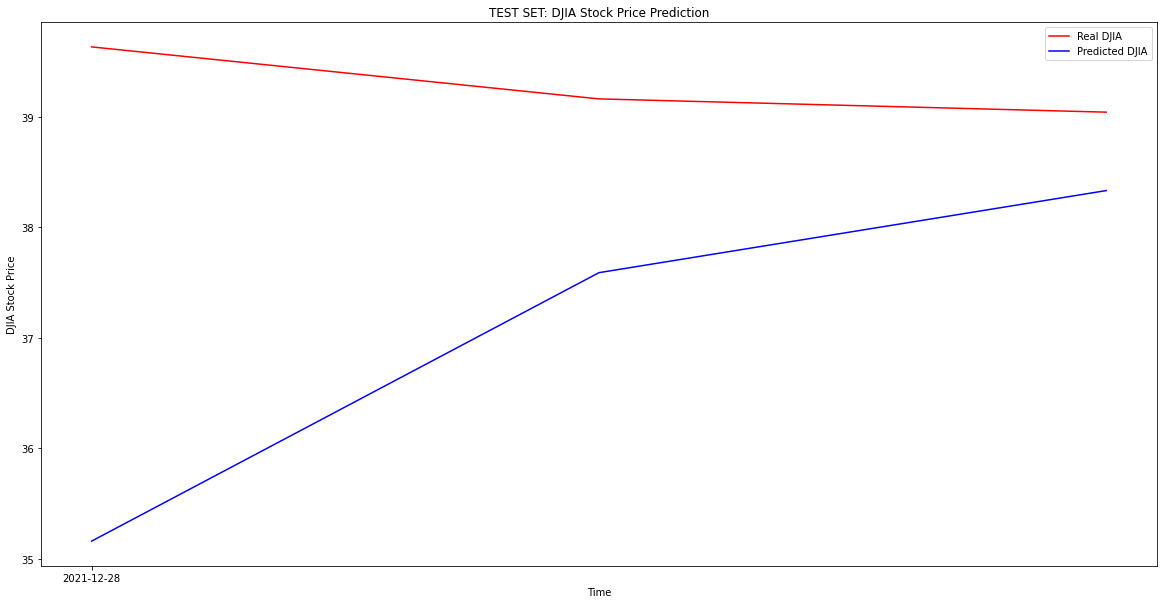

RMSE: 2.7652992209636693


In [ ]:
# Visualising the results
date = test_df[seq_length+step_predict:test_df.shape[0]].Date.values
plt.figure(figsize=(20,10))
plt.plot(date, test_price, color = 'red', label = 'Real DJIA')
plt.plot(date, test_predicted, color = 'blue', label = 'Predicted DJIA')
plt.xticks(np.arange(0,len(test_predicted),50))
plt.title('TEST SET: DJIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('DJIA Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(test_price, test_predicted, squared=False)}')